# Cleaning yield monitor data & obtain management zones

#### Final Project AGRON 845 - Spring 2024
#### Student: Emmanuela van Versendaal

## Local Moran Method

### Introduction & Objectives


Yield monitor data allows farmers to measure variability within the field over time and space, providing them with the chance to apply crop inputs precisely when and where they are necessary. However, yield monitor data often contains errors caused by the harvesting equipment. Therefore, it is crucial to identify this erroneous data and clean the yield monitor datasets to obtain the most accurate maps possible (Khosla and Flynn, 2008). With high-quality yield maps, management zones can be established within the field. These management zone maps are essential for implementing variable input rates across the field, thereby enhancing crop yields, reducing costs, and preventing environmental contamination (Bullock et al., 2002).

The aim of this project is to develop a workflow to clean yield monitor data and delineate management zones within a farm.


### 1. Import modules

In [ ]:
## Run in separate cell ##
#!pip install geopandas
#pip install libpysal
#!pip install esda

In [2]:
# Import modules
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## for local moran
from scipy.stats import skew
from libpysal.weights import KNN
from esda.moran import Moran_Local

## Create grid
from shapely.geometry import box # create the grids

# CLustering using K-Means
from sklearn.cluster import KMeans
from scipy.interpolate import griddata

### 2. Import the data

#### 2.1. Import the dataset
Import the yield monitor shapefile documents.

In [3]:
df = gpd.read_file('../1_Data/shp_farm/Corn_2017.shp')
#df.to_crs(epsg=4326)
df.head(3)

,DISTANCE,SWATHWIDTH,VRYIELDVOL,SECTIONID,Crop,WetMass,Moisture,Time,Heading,VARIETY,Elevation,IsoTime,Machine,VEHICLSPEE,DRYMATTER,geometry
0,4.055719,20.0,234.318838,138,173,13416.410144,16.87,10/21/2017 1:33:44 PM,90.109047,P0589AM,664.636987,2017-10-21T13:33:44.405Z,1,2.759743,83.13,POINT (-87.90551 40.58310)
1,4.055719,20.0,229.506035,138,173,13140.843137,16.87,10/21/2017 1:33:45 PM,89.859047,P0589AM,664.594336,2017-10-21T13:33:45.405Z,1,2.765263,83.13,POINT (-87.90549 40.58310)
2,4.088527,20.0,197.023091,138,173,11280.964940,16.87,10/21/2017 1:33:46 PM,89.729047,P0589AM,664.597617,2017-10-21T13:33:46.406Z,1,2.784847,83.13,POINT (-87.90548 40.58310)


#### 2.2. Data wrangling & checking
Convert dates in the dataset to GeoPandas datetime format

In [4]:
df['VRYIELDVOL'] = df['VRYIELDVOL'].round(0)

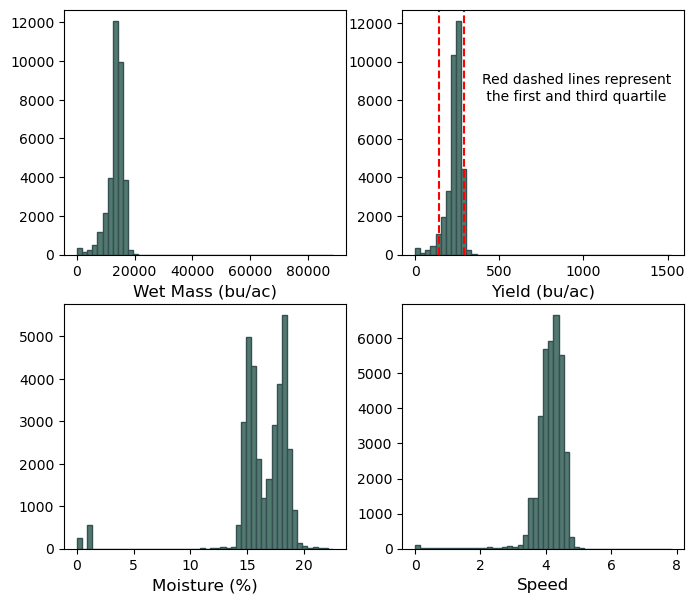

In [14]:
## plot some variables to check ##
edgecolor = '#354f52'
color = "#52796f"
bins = 50

plt.figure(figsize=(8,7))

plt.subplot(2,2,1)
plt.hist(df["WetMass"], edgecolor = edgecolor, color = color, bins = bins)
plt.xlabel("Wet Mass (bu/ac)", size=12)


plt.subplot(2,2,2)
plt.hist(df["VRYIELDVOL"], edgecolor = edgecolor, color = color, bins = bins)
plt.axvline(df["VRYIELDVOL"].quantile(0.05),
            color='red', linestyle = '--')
plt.axvline(df["VRYIELDVOL"].quantile(0.95),
            color='red',linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.annotate('Red dashed lines represent \n the first and third quartile', xy = (400,8000))

plt.subplot(2,2,3)
plt.hist(df["Moisture"], edgecolor = edgecolor, color = color, bins = bins)
plt.xlabel("Moisture (%)", size=12)

plt.subplot(2,2,4)
plt.hist(df["VEHICLSPEE"], edgecolor = edgecolor, color = color, bins = bins)
plt.xlabel("Speed", size=12)

plt.show()

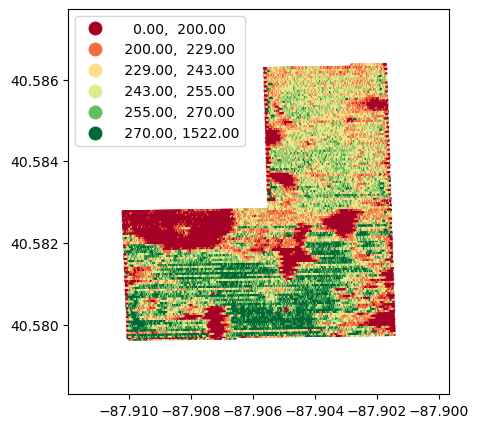

In [10]:
## Plot the yield map ##
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.ticklabel_format(useOffset=False)

# Set margins (to have more space between the map and axis)
ax.set_xmargin(0.2)  
ax.set_ymargin(0.2) 

# Map settings
original_yield_map = df.plot(ax = ax,
                             figsize = (7, 7),
                             column = 'VRYIELDVOL',
                             scheme = 'Quantiles',
                             k = 6,
                             cmap = 'RdYlGn', #df['VRYIELDVOL'].min(), vmax=df['VRYIELDVOL'].max(),
                             legend = True,
                             marker = '.', 
                             markersize =3.5,
                             legend_kwds={'loc': 'upper left'}) 


### 3. Clean the maps


The methodology to be used in this case for cleaning yield monitor maps is that used by Cordoba et al. (2009). This methodology consists of two steps: removing outliers and cleaning according to the Local Moran Method.

3.1. Removing outliers: This involves removing yield values that are more than three standard deviations above or below the mean. In this step, global outliers located at the extremes of the dataset are eliminated, but not local extremes (spatial outliers).

3.2. Local Moran: This step involves eliminating spatial outliers, also known as inliers, which are data points that significantly differ from their neighborhood but are within the general range of variation of the dataset. This inlier identification step is based on Anselin (1995) methodology, known as the local Moran's spatial autocorrelation index. Given a group of data belonging to different neighborhoods, Local Moran is applied to each data point individually, indicating the degree of similarity or difference between the value of an observation and the values of its neighbors. To calculate the Moran's Index, it is necessary to identify the neighborhood for each data point, which is the domain where there are data that can be interpreted as spatial neighbors and will be used as a reference to determine whether the data point is different from its neighbors.

Source: "https://www.researchgate.net/profile/Monica-Balzarini/publication/341282116_Guia_para_el_analisis_de_datos_espaciales_Aplicaciones_en_agricultura/links/5f4e253fa6fdcc14c505fedd/Guia-para-el-analisis-de-datos-espaciales-Aplicaciones-en-agricultura.pdf"

#### 3.1. Delete outliers

In [7]:
## Check the skewness of the yield data ##
print("Skewness:", skew(df["VRYIELDVOL"]))

Skewness: -0.4727121769663919


Remove outliers based on SD (+- 3)

In [8]:
## Calculate SD ##
mean_yield = df["VRYIELDVOL"].mean()
sd_yield = df["VRYIELDVOL"].std()
LI = mean_yield - 3 * sd_yield
LS = mean_yield + 3 * sd_yield

## Obtain the inliers ##
Yield_in = df[(df["VRYIELDVOL"] > LI) & (df["VRYIELDVOL"]< LS)]

In [10]:
## Check the new value of skewness ##
print("Skewness:", skew(Yield_in["VRYIELDVOL"]))

Skewness: -1.0962596108560911


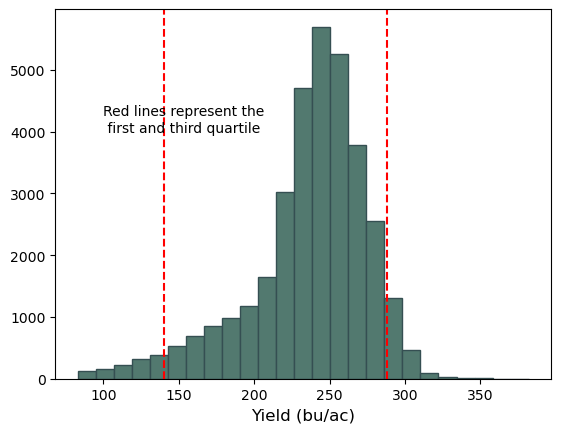

In [11]:
## Plot the new distribution ##
plt.hist(Yield_in["VRYIELDVOL"], bins = 25, color = "#52796f", edgecolor = '#354f52')
plt.axvline(df["VRYIELDVOL"].quantile(0.05),
            color='red', linestyle = '--')
plt.axvline(df["VRYIELDVOL"].quantile(0.95),
            color='red',linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.annotate('Red lines represent the \n first and third quartile', xy = (100,4000))
plt.show()

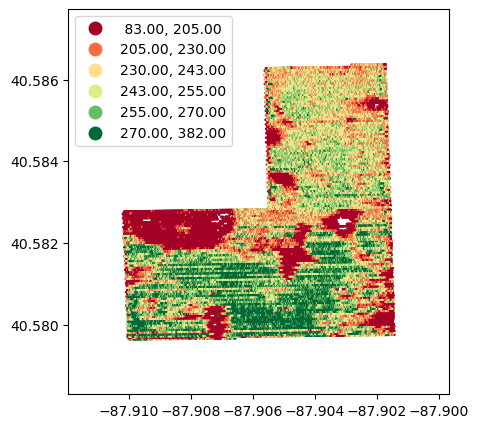

In [12]:
## Plot the yield map with the removed outliers (sd><3) ##
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.ticklabel_format(useOffset=False)

# Set margins (to have more space between the map and axis)
ax.set_xmargin(0.2)  
ax.set_ymargin(0.2) 

# Map settings
out_yield_map = Yield_in.plot(ax = ax,
                             figsize = (7, 7),
                             column = 'VRYIELDVOL',
                             scheme = 'Quantiles',
                             k = 6,
                             cmap = 'RdYlGn',  legend = True,
                             marker = '.',  markersize =3.5,
                             legend_kwds={'loc': 'upper left'}) 

#### 3.2. Local Moran

In [179]:
# Create spatial weights based on KNN contiguity
k = 15
w = KNN.from_dataframe(Yield_in, k = k)

In [180]:
y = Yield_in['VRYIELDVOL'].values

# Compute Local Moran's I using the KNN spatial weights
local_moran_knn = Moran_Local(y, w)

In [181]:
# Identify significant locations (p-value < 0.05)
sig = local_moran_knn.p_sim < 0.05

# Identify spatial outliers (High-Low or Low-High)
hot_spots = local_moran_knn.q == 2
cold_spots = local_moran_knn.q == 4
outliers = np.logical_or(hot_spots, cold_spots)
local_outliers = Yield_in[sig & outliers]

# Obtain inliers
# Create a mask that excludes the outliers
mask = ~Yield_in.index.isin(local_outliers.index)

# Apply the mask to Yield_in to get a DataFrame without the outliers
Yield_in_cleaned = Yield_in[mask]

(array([17851.,     0.,     0.,  3689.,     0.,     0., 10181.,     0.,
            0.,  2312.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

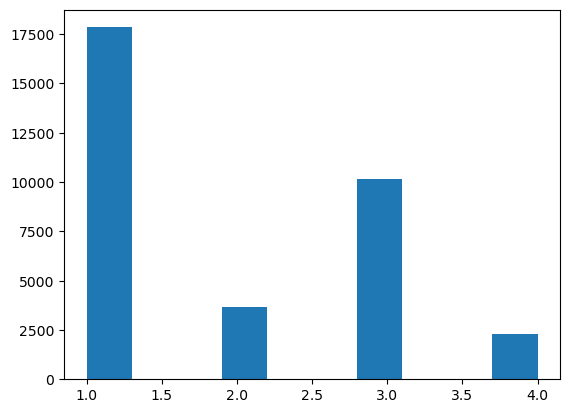

In [182]:
plt.hist(local_moran_knn.q)

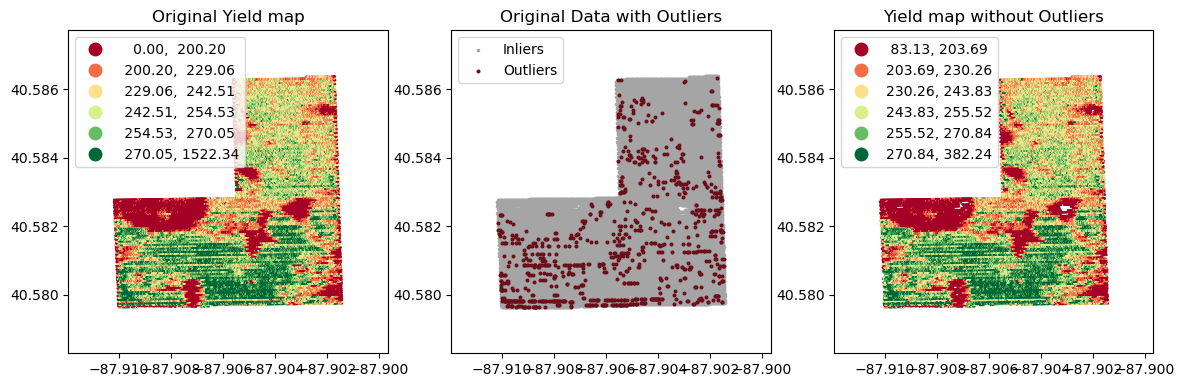

In [184]:
# Colors
original = '#a5a5a5'
out_col = '#6b0f1a'

# Create a figure and axes objects for two subplots
fig, (ax,ax1, ax2) = plt.subplots(1, 3, figsize=(14, 6))  # Adjust the figsize to fit your needs

## MAP 1  - original yield map##
ax.set_xmargin(0.2)
ax.set_ymargin(0.2)
df.plot(ax = ax,
        #figsize = (7, 7),
        column = 'VRYIELDVOL',
        scheme = 'Quantiles',
        k = 6,
        cmap = 'RdYlGn', 
        legend = True,
        marker = '.', markersize=2.5,
        legend_kwds={'loc': 'upper left'}) 
ax.set_title("Original Yield map")


## MAP 2 ##
# Set margins (to have more space between the map and axis)
ax1.set_xmargin(0.2)
ax1.set_ymargin(0.2)
# Plot the base layer of points on the first subplot
Yield_in.plot(ax=ax1, color=original, markersize=2.5, label='Inliers')
# Highlight significant local outliers on the same axes
local_outliers.plot(ax=ax1, color=out_col, markersize=3.5, label='Outliers')
ax1.legend()
ax1.set_title("Original Data with Outliers")

## MAP 3 ##
# Set margins (to have more space between the map and axis)
ax2.set_xmargin(0.2)
ax2.set_ymargin(0.2)
Yield_in_cleaned.plot(ax = ax2,
                      column = 'VRYIELDVOL',
                      scheme = 'Quantiles',
                      k = 6,
                      cmap = 'RdYlGn', legend = True,
                      marker = '.', markersize =2.5,
                      legend_kwds={'loc': 'upper left'}) 
ax2.set_title("Yield map without Outliers")

# Show the plot
plt.show()

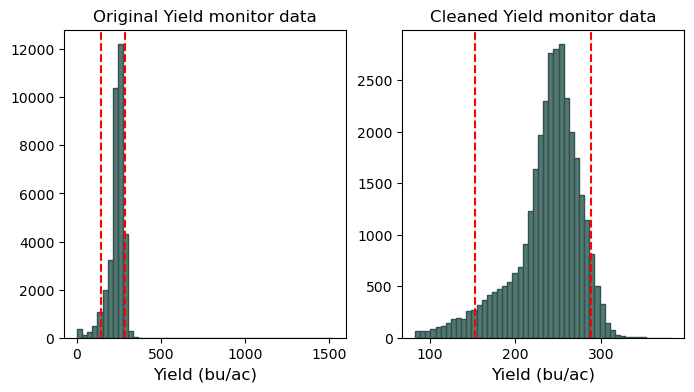

In [185]:
edgecolor = '#354f52'
color = "#52796f"
bins = 50

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(df["VRYIELDVOL"], edgecolor = edgecolor, color = color, bins = bins)
plt.axvline(df["VRYIELDVOL"].quantile(0.05), color='red', linestyle = '--')
plt.axvline(df["VRYIELDVOL"].quantile(0.95), color='red', linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.annotate('Red lines represent the \n first and third quartile', xy = (3500,8000))
plt.title('Original Yield monitor data')

plt.subplot(1,2,2)
plt.hist(Yield_in_cleaned["VRYIELDVOL"], edgecolor = edgecolor, color = color, bins = bins)
plt.axvline(Yield_in_cleaned["VRYIELDVOL"].quantile(0.05), color='red', linestyle = '--')
plt.axvline(Yield_in_cleaned["VRYIELDVOL"].quantile(0.95), color='red', linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.title('Cleaned Yield monitor data')


plt.show()

### 4. Management zones


#### 4.1. Define field boundary

In [11]:
# Read field boundaries
boundary = gpd.read_file('../1_Data/polygons/Polygon.shp')

##### Creat grid map and clip cells

In [12]:
xmin, ymin, xmax, ymax = boundary.boundary.total_bounds

# Define cell size
xdelta = (xmax - xmin)/45
ydelta = (ymax - ymin)/45

# Create and empty array to save the grid
grid = np.array([])

for x in np.arange(xmin, xmax, xdelta):
    for y in np.arange(ymin, ymax, ydelta):
        cell = box(x, y, x+xdelta, y+ydelta)
        grid = np.append(grid, cell)
        
gdf_grid = gpd.GeoDataFrame(grid, columns=['geometry'], crs = df.crs)

# Clip cells
gdf_grid = gpd.clip(gdf_grid, boundary['geometry'])
gdf_grid.reset_index(inplace=True, drop=True)

##### Plot grid map

<Axes: >

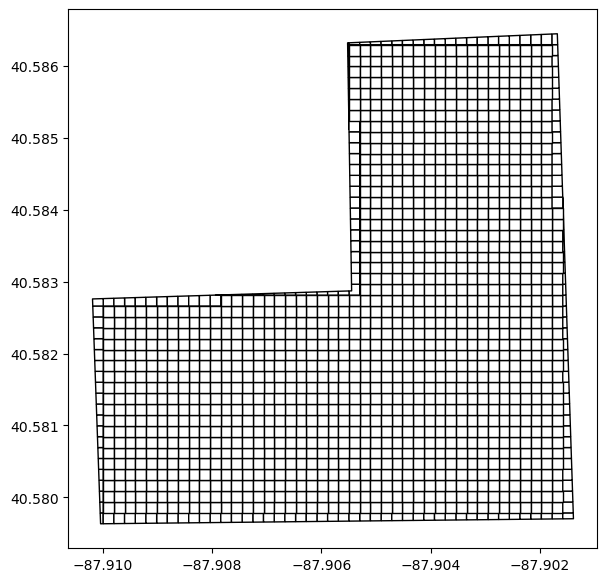

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.ticklabel_format(useOffset=False)

gdf_grid.plot(ax = ax, facecolor = 'w', edgecolor = 'k')

#### 4.2. Median yield

Iteration over each grid cell and compute median yield value.

In [233]:
M = []

for k, row in gdf_grid.iterrows():
    
    idx = (Yield_in_cleaned.geometry).within(row.geometry)
    
    val = Yield_in_cleaned.loc[idx, 'VRYIELDVOL'].median()
    M.append(val)
    
gdf_grid['yield'] = M 

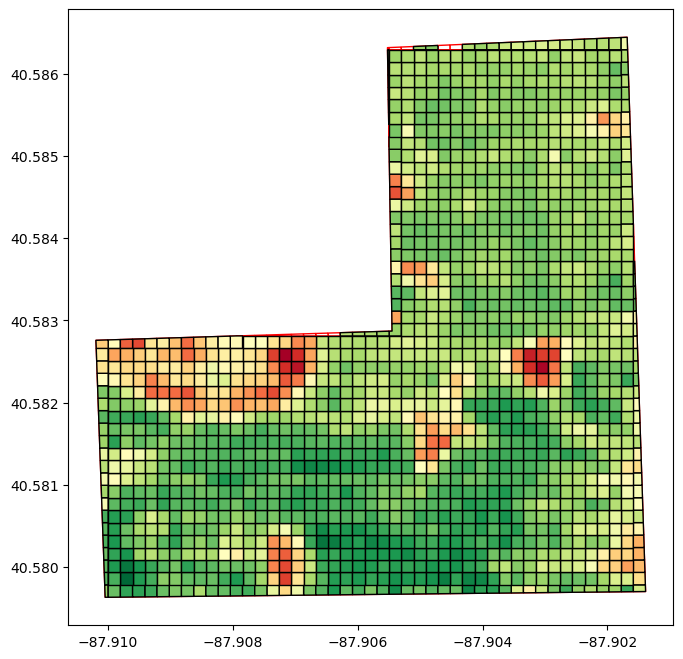

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.ticklabel_format(useOffset=False)

gdf_grid.plot(ax=ax, facecolor='w', edgecolor='red')
final_yield_map = gdf_grid.plot(ax=ax,column = 'yield', edgecolor = 'k', cmap = 'RdYlGn')

#fig.savefig('final_yield_map.png')

plt.show()

#### 4.3. Delineate management zone

For this k-Means clustering methodology we will use

In [235]:
# CLustering using K-Means
gdf_grid.dropna(inplace=True)
kmeans_info = KMeans(n_clusters=3, n_init='auto').fit(gdf_grid['yield'].values.reshape(-1,1))
gdf_grid['zone'] = kmeans_info.labels_.flatten()
gdf_grid.head()

C:\Users\evanversendaal\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


,geometry,yield,zone
0,"POLYGON ((-87.91005 40.57979, -87.90999 40.579...",240.242193,2
1,"POLYGON ((-87.90999 40.57963, -87.90999 40.579...",259.730774,0
2,"POLYGON ((-87.90491 40.57968, -87.90491 40.579...",265.711893,0
3,"POLYGON ((-87.90354 40.57969, -87.90354 40.579...",215.285393,2
4,"POLYGON ((-87.90941 40.57964, -87.90941 40.579...",272.158517,0


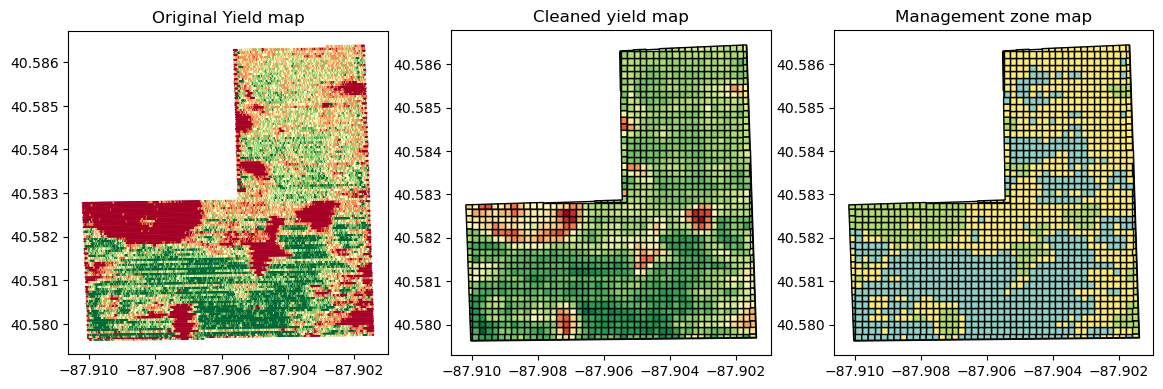

In [250]:
# Colors
original = '#a5a5a5'
out_col = '#6b0f1a'

# Create a figure and axes objects for two subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 6))  # Adjust the figsize to fit your needs

## MAP 1  - original yield map##
df.plot(ax = ax[0],
        column = 'VRYIELDVOL',
        scheme = 'Quantiles',
        cmap = 'RdYlGn',  legend = False,
        marker = '.', markersize=2.5,
        legend_kwds={'loc': 'upper left'}) 
ax[0].set_title("Original Yield map")

## MAP 2  - Cleaned yield map##
boundary.plot(ax=ax[1], facecolor='w', edgecolor='k')
gdf_grid.plot(ax=ax[1], column='yield', edgecolor='k', cmap='RdYlGn')
ax[1].set_title("Cleaned yield map")


## MAP 3  - Management zone map ##
boundary.plot(ax=ax[2], facecolor='w', edgecolor='k')
gdf_grid.plot(ax=ax[2], column='zone', edgecolor='k', cmap='Set3')
ax[2].set_title("Management zone map")

ax[0].ticklabel_format(useOffset=False)
ax[1].ticklabel_format(useOffset=False)
ax[2].ticklabel_format(useOffset=False)

# Show the plot
plt.show()

## References

Anselin, L. (1995). Local indicators of spatial association—LISA. Geographical analysis, 27(2), 93-115. https://doi.org/10.1111/j.1538-4632.1995.tb00338.x

Bullock, D.S., Lowenberg‐DeBoer, J., Swinton, S.M., 2002. Adding value to spatially managed inputs by understanding site‐specific yield response. Agricultural Economics 27, 233–245. https://doi.org/10.1111/j.1574-0862.2002.tb00119.x

Khosla, R. and Flynn, B., 2008. Understanding and cleaning yield monitor data. Soil Science Step‐by‐Step Field Analysis, pp.113-130. https://doi.org/10.2136/2008.soilsciencestepbystep.c9